# Preambule

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sqlalchemy import create_engine
from astropy.io import fits

In [2]:
from castor import spec2sqr

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["image.cmap"] = "jet"

## Load table into dataframe

In [5]:
names = ['obsid', 'designation', 'obsdate', 'mjd', 'planid', 'spid', 'fiberid',
         'objra', 'objdec', 'snru', 'snrg', 'snrr', 'snri', 'snrz', 'objtype',
         'class', 'subclass', 'magtype', 'mag1', 'mag2', 'mag3', 'mag4', 'mag5',
         'mag6', 'mag7', 'tsource', 'fibertype', 'tfrom', 't_info', 'rv',
         'rv_err', 'logg', 'logg_err', 'teff', 'teff_err', 'feh', 'feh_err']

In [15]:
data = pd.read_csv("dr1_stellar_final.csv.gz",
                   header=None, names=names, skiprows=1,
                   sep="|", na_values=[-9999.00, "NULL"])

In [16]:
basename = data["mjd"].map("spec-{}-".format)\
         + data["planid"].map("{}".format)\
         + data["spid"].map("_sp{:02d}-".format)\
         + data["fiberid"].map("{:03d}".format)
data["basename"] = basename

In [17]:
data.head()

,obsid,designation,obsdate,mjd,planid,spid,fiberid,objra,objdec,snru,...,t_info,rv,rv_err,logg,logg_err,teff,teff_err,feh,feh_err,basename
0,66101038,J235901.93+003543.3,2012-10-12,56213,EG000023N024031B01,1,38,359.758071,0.595387,1.32,...,NaN,-3.58,14.78,4.270,0.584,5738.29,260.80,-0.209,0.557,spec-56213-EG000023N024031B01_sp01-038
1,66514126,J055146.35+341529.8,2012-10-12,56213,GAC090N33B1,14,126,87.943125,34.258281,0.00,...,NaN,54.16,5.90,1.971,0.349,3942.62,25.94,0.024,0.163,spec-56213-GAC090N33B1_sp14-126
2,66212155,J013256.17-004522.2,2012-10-12,56213,EG012606S021203F03,12,155,23.234072,-0.756194,4.88,...,NaN,64.64,8.26,2.558,0.668,5328.32,122.11,-0.294,0.375,spec-56213-EG012606S021203F03_sp12-155
3,66504055,J060143.23+331629.8,2012-10-12,56213,GAC090N33B1,4,55,90.430127,33.274949,0.84,...,NaN,-5.82,7.34,2.063,0.470,4429.66,86.37,-0.310,0.286,spec-56213-GAC090N33B1_sp04-055
4,66503103,J055350.90+334252.1,2012-10-12,56213,GAC090N33B1,3,103,88.462116,33.714490,1.81,...,NaN,22.08,16.20,3.912,0.696,5510.89,353.30,-0.254,0.773,spec-56213-GAC090N33B1_sp03-103


In [9]:
eng = create_engine("sqlite:///lamost.db")
data.to_sql("dr1", eng, if_exists="replace")

## Simple Query Language

In [10]:
eng = create_engine("sqlite:///lamost.db")
tip = ["teff", "logg", "feh"]
top = ["teff_err", "logg_err", "feh_err"]
sql = "SELECT {} FROM dr1"\
      .format(",".join(["basename"]+tip+top))
data = pd.read_sql(sql, eng)

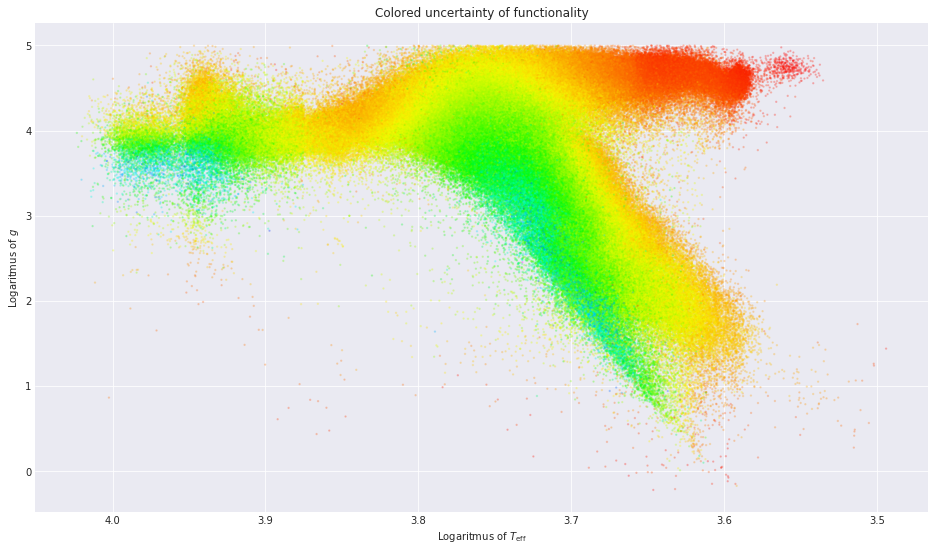

In [11]:
plt.title("Colored uncertainty of functionality")
plt.xlabel("Logaritmus of $T_\mathrm{eff}$")
plt.ylabel("Logaritmus of $g$")
plt.scatter(np.log10(data["teff"]), data["logg"], s=2,
            c=data["logg_err"], cmap="hsv", alpha=0.2);
plt.gca().invert_xaxis()

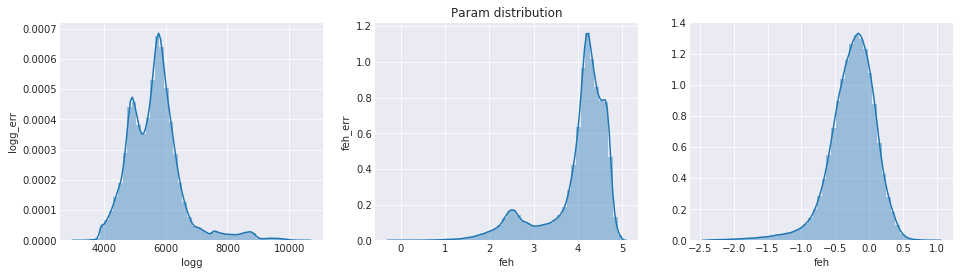

In [12]:
plt.figure(figsize=(16,4))
for i, name in enumerate(tip):
    if i == 2: plt.title("Param distribution")
    plt.subplot(131+i)
    plt.xlabel(tip[i])
    plt.ylabel(top[i])
    sns.distplot(data[name])

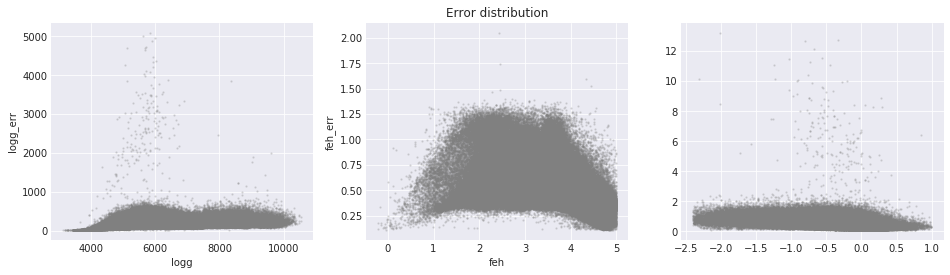

In [13]:
plt.figure(figsize=(16,4))
for i, name in enumerate(tip):
    if i == 2: plt.title("Error distribution")
    plt.xlabel(tip[i])
    plt.ylabel(top[i])
    plt.subplot(131+i)
    plt.scatter(data[name], data[top[i]],
                s=2, c="gray", alpha=0.2)

## Download

```python
URL = "ftp://cdsarc.u-strasbg.fr/pub/cats/V/146/LAMOST/fits/"
prog = IntProgress(min=0, max=len(data)); display(prog)
with open("lamost.url", "w") as file:
    for i in range(len(data)):
        if np.random.randint(101) == 8:  ## kvantové orbitální dělo
            line = data.iloc[i]
            FITS = line["basename"]+".fits"
            if not os.path.exists(os.path.join("/mnt/arch/LAMOST/dr1/sample/", FITS)):
                file.write("{}{}/{}\n".format(URL, line["planid"], FITS))
        if i % 1000: prog.value = i;
```

```bash
$ cd /mnt/arch/LAMOST/dr1/sample/
$ wget -i ~/__.xXx.__/lamost.url
```

In [19]:
# stvoření lamostu z obsahu vzorku
with open("lamost.lst", "w") as last:
    filenames = glob.glob("/mnt/arch/LAMOST/dr1/sample/*.fits")
    for funy in filenames:
        name = os.path.basename(funy.strip(".fits\n"))
        last.write(name+"\n")

## Spectral normalization

In [25]:
lamost = open("lamost.lst").readlines()
progres = IntProgress(min=0, max=len(lamost))
display(progres)
for name in lamost:
    name = name.strip()
    if os.path.exists("lamos/"+name+".npy"): #!NOT
        flux = fits.getdata("/mnt/arch/LAMOST/dr1/sample/"+name+".fits")[0]
        sqr = spec2sqr(robust_scale(flux.reshape(-1, 1)), a=62)
        np.save("lamost/"+name+".npy", sqr)
    progres.value += 1

## Preview

In [26]:
lamost = open("lamost.lst").readlines()
lama = np.random.randint(len(lamost))
name = lamost[lama].strip()
path = "/mnt/arch/LAMOST/dr1/sample/"+name+".fits"
flux = fits.getdata(path)[0]
N = fits.getval(path, "NAXIS1")
l = fits.getval(path, "CRVAL1")
s = fits.getval(path, "CD1_1")
wave = np.logspace(l, l+N*s, N)
wave.shape, wave.min(), wave.max()

((3909,), 3699.9853117285957, 9101.2281202918894)

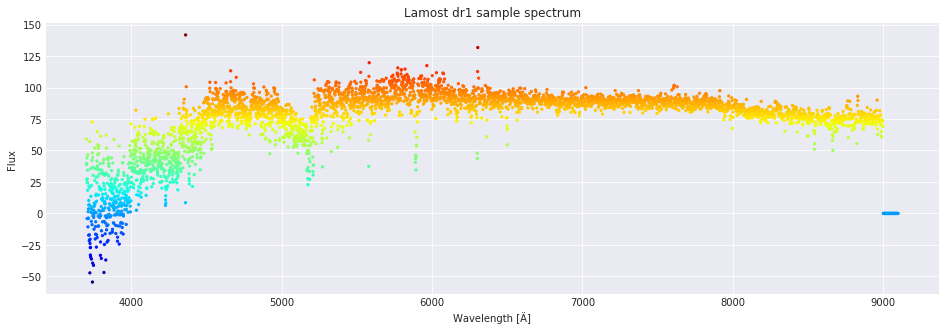

In [27]:
plt.figure(figsize=(16,5))
plt.title("Lamost dr1 sample spectrum")
plt.xlabel("Wavelength [Ä]")
plt.ylabel("Flux")
plt.scatter(wave, flux, c=flux, s=5)

In [28]:
# zápis předpokládaných výsledků
np.save("lamost.npy", data[tip].values)